In [1]:
#Import relevant modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Create a function to turn seconds into a text string

def secstostr(secs):
    secs = int(secs)
    minutespart = int(secs/60)
    secondspart = secs-minutespart*60
    string = '%02dm %02ds' % (minutespart,secondspart)
    return string


In [62]:
#------------- set foundation variables and constants
g = 9.8067   # gravity
weight = 85  # weight : rider plus bicycle
crr = 0.0025 # Rolling resistance coefficient
cd = 0.6     # Drag coefficient
fa = 0.6     # Frontal area
rho = 1.25   # Air density
headwindmps = 0 # Assuming this is straight on on both segments

#-------------- the following are further simplification of constants for power calculations
CROLL = g * weight * crr
CGRAV = g * weight
CDRAG = fa * cd * rho * 0.5 

#-------------- power constraints, all expressed as a percentage of FTP
Ftp=250
MaxInstPowerPerc=1.5
MaxAvgPowerPerc = 1.2
MinInstPowerPerc = 0.5
MinAvgPowerPerc = 0.5

MaxInstPower = Ftp * MaxInstPowerPerc
MaxAvgPower  = Ftp * MaxAvgPowerPerc
MinInstPower = Ftp * MinInstPowerPerc
MinAvgPower  = Ftp * MinAvgPowerPerc

#-------------- segment definitions
Seg1Gradient = 0.06  # y/x
Seg1Distance = 1500  # metres
Seg2Gradient = -0.03
Seg2Distance = 1700


#Set range of speeds for which power will be calculated and define a dataframe for segment one and a separate one for segment 2

seg1data = pd.DataFrame(data=np.arange(1,20.1,0.05).tolist(),columns=['speedmps'])

seg1data['speedkph']= seg1data.speedmps*3.6
seg1data['power']=np.nan
seg1data['totalwork']=np.nan
seg1data['durationsec']=np.nan
seg1data['durationtext']='not known'

seg2data = pd.DataFrame(data=np.arange(1,20.1,0.05).tolist(),columns=['speedmps2'])
seg2data['speedkph2']= seg1data.speedmps*3.6
seg2data['power2']=np.nan
seg2data['totalwork2']=np.nan
seg2data['durationsec2']=np.nan
seg2data['durationtext2']='not known'

seg1data.durationsec = Seg1Distance / seg1data.speedmps
seg2data.durationsec2 = Seg2Distance / seg2data.speedmps2


#Calculate variables for Segment 1

seg1data.power = CGRAV * np.sin(Seg1Gradient) * seg1data.speedmps \
                    + CROLL * np.cos(Seg1Gradient) * seg1data.speedmps \
                    + CDRAG * seg1data.speedmps**2 * seg1data.speedmps \

seg1data.totalwork = seg1data.power * seg1data.durationsec
seg1data.durationtext = seg1data.durationsec.apply(secstostr)

#Remove all rows that do not fall within the min and max inst power constraints
 
seg1data.drop(seg1data[(seg1data.power < MinInstPower) | (seg1data.power > MaxInstPower)].index,inplace=True)


#Calculate variables for Segment 2
seg2data.power2 = CGRAV * np.sin(Seg2Gradient) * seg2data.speedmps2 \
                    + CROLL * np.cos(Seg2Gradient) * seg2data.speedmps2 \
                    + CDRAG * seg2data.speedmps2**2 * seg2data.speedmps2 \

seg2data.totalwork2 = seg2data.power2 * seg2data.durationsec2
seg2data.durationtext2 = seg2data.durationsec2.apply(secstostr)
        

# Remove all rows where the power is negative or higher than the max instant power    
seg2data.drop(seg2data[(seg2data.power2 < 0) | (seg2data.power2 > MaxInstPower)].index,inplace=True) 



#Create a new dataframe that is a cartesian join on the two segment dataframes

seg1data['key'] = 0
seg2data['key'] = 0

cartseg = seg1data.merge(seg2data, how='outer')

cartseg['routedurationsec']=cartseg.durationsec+ cartseg.durationsec2
cartseg['routework']=cartseg.totalwork + cartseg.totalwork2
cartseg['averagepower']=cartseg.routework/cartseg.routedurationsec
cartseg['routedurationtext'] = cartseg.routedurationsec.apply(secstostr)

#Create a dataframe with just the essential columns and only with rows that honour the minimum and maximum average power

speedoptions = cartseg[(cartseg.averagepower >= MinAvgPower) & (cartseg.averagepower <= MaxAvgPower)] \
                        [['routedurationtext','averagepower','speedkph','power','durationtext','speedkph2',\
                          'power2','durationtext2','routedurationsec']]


#Create sensible column names

speedoptions.rename(columns={'speedkph':'Seg1_Speed','speedkph2':'Seg2_Speed','durationtext':'Seg1_Duration',\
                             'durationtext2':'Seg2_Duration','routedurationtext':'Duration','averagepower':'Avg_Power',\
                             'power':'Seg1_Power','power2':'Seg2_Power',\
                             'routedurationsec':'DurationInSeconds'},inplace=True)

#Change floats into ints for easier readability of the dataframe

speedoptions.DurationInSeconds = speedoptions.DurationInSeconds.astype(int)
speedoptions.Avg_Power = np.round(speedoptions.Avg_Power,0).astype(int)
speedoptions.Seg1_Power = np.round(speedoptions.Seg1_Power,0).astype(int)
speedoptions.Seg2_Power = np.round(speedoptions.Seg2_Power,0).astype(int)


#Sort speedoptions from shortest to longest
speedoptions.sort_values(by = ['DurationInSeconds'], axis=0, ascending=True, inplace=True)    


#Print the results

print (f'You are riding {round(Seg1Distance/1000,2)}km at {Seg1Gradient*100}% and\
 then {round(Seg2Distance/1000,2)}km at {Seg2Gradient*100}%')

print(f'You don\'t want to go higher than {MaxInstPower} watts on either segment or average more than {MaxAvgPower} watts over the whole ride')
print(f'You don\'t want to go lower than {MinInstPower} watts on either segment or average less than {MinAvgPower} watts over the whole ride')

if len(speedoptions) > 0:
    
    fastest = speedoptions.iloc[0]
    
    print(f'\nYou can achieve a time of {fastest.Duration} if you ride the first {round(Seg1Distance/1000,2)}km \
in {fastest.Seg1_Duration} at {fastest.Seg1_Power} watts ({round(fastest.Seg1_Speed,1)}km/h)')
    
    print(f'and the second {round(Seg2Distance/1000,2)}km in {fastest.Seg2_Duration} at {fastest.Seg2_Power} watts \
({round(fastest.Seg2_Speed,1)}km/h), averaging {fastest.Avg_Power} watts over the ride')

else:
    print('There are no options available to you, try lowering your minimum watts or increasing your maximum watts')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(cartseg[['power','power2','averagepower']])
        
fastest = speedoptions.iloc[0:20]
display(fastest[['Duration','Seg1_Power','Seg2_Power','Avg_Power','Seg1_Duration','Seg2_Duration']])

You are riding 1.5km at 6.0% and then 1.7km at -3.0%
You don't want to go higher than 375.0 watts on either segment or average more than 300.0 watts over the whole ride
You don't want to go lower than 125.0 watts on either segment or average less than 125.0 watts over the whole ride

You can achieve a time of 06m 18s if you ride the first 1.5km in 04m 03s at 373 watts (22.1km/h)
and the second 1.7km in 02m 14s at 166 watts (45.5km/h), averaging 299 watts over the ride


,Duration,Seg1_Power,Seg2_Power,Avg_Power,Seg1_Duration,Seg2_Duration
7043,06m 18s,373,166,299,04m 03s,02m 14s
7042,06m 18s,373,161,297,04m 03s,02m 14s
7040,06m 19s,373,153,294,04m 03s,02m 15s
7041,06m 19s,373,157,296,04m 03s,02m 15s
6952,06m 19s,369,170,299,04m 05s,02m 13s
6951,06m 20s,369,166,297,04m 05s,02m 14s
6950,06m 20s,369,161,295,04m 05s,02m 14s
6862,06m 20s,365,178,300,04m 07s,02m 12s
7038,06m 20s,373,145,291,04m 03s,02m 17s
7039,06m 20s,373,149,292,04m 03s,02m 16s


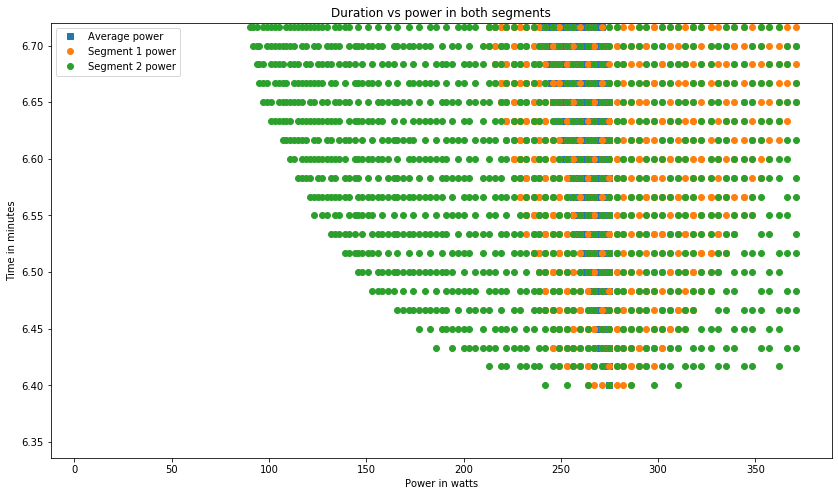

In [55]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)
ax.set_ylim(speedoptions.DurationInSeconds.min()*0.99/60,speedoptions.DurationInSeconds.min()*1.05/60)
plt.plot(speedoptions.Avg_Power,speedoptions.DurationInSeconds/60,'s')
plt.plot(speedoptions.Seg1_Power,speedoptions.DurationInSeconds/60,'o')
plt.plot(speedoptions.Seg2_Power,speedoptions.DurationInSeconds/60,'o')
plt.ylabel('Time in minutes')
plt.xlabel('Power in watts')
plt.title('Duration vs power in both segments')
plt.legend(['Average power','Segment 1 power','Segment 2 power'])
plt.show()

    